# 🤖 Machine Learning: K-Means Neighborhood Clustering

## 🎯 Business Problem

**Goal**: Automatically group Berlin districts into similar clusters for comparative analysis.

**Questions to answer**:
- Which districts are similar to each other?
- Can we identify natural groupings (urban vs suburban, safe vs risky)?
- Which cluster offers the best value for investors?

**Approach**: Unsupervised machine learning with K-Means clustering

---

## 🤖 Why This IS Machine Learning

**Unlike Safety Scoring (rule-based algorithm):**
- ✅ Algorithm LEARNS patterns from data
- ✅ No human-defined rules
- ✅ Discovers clusters automatically
- ✅ Unsupervised learning (no labels)

**K-Means**:
- Iteratively finds optimal cluster centers
- Minimizes within-cluster variance
- Adapts based on data distribution

---

## 📚 Step 1: Import Libraries

In [22]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
np.random.seed(42)

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


## 🗄️ Step 2: Load All Integrated Data

In [23]:
# Connect to database
DB_PATH = "../database/berlin_intelligence.db"
conn = sqlite3.connect(DB_PATH)

# Load integrated data (crime + population + prices)
query = """
SELECT 
    c.district,
    c.district_id,
    p.total_population,
    SUM(c.total_number_cases) as total_crimes,
    ROUND((SUM(c.total_number_cases) * 100000.0 / p.total_population), 0) as crime_per_100k,
    l.avg_price
FROM crime_statistics c
LEFT JOIN district_population p ON c.district_id = p.district_id
LEFT JOIN (
    SELECT 
        district_name as district,
        AVG(standard_land_value) as avg_price
    FROM land_prices
    WHERE typical_land_use_type LIKE 'W%'
    GROUP BY district_name
) l ON c.district = l.district
WHERE p.total_population IS NOT NULL
GROUP BY c.district, c.district_id, p.total_population, l.avg_price
"""

df = pd.read_sql_query(query, conn)
conn.close()

# Add population density
df['population_density'] = df['total_population'] / 100  # Simplified metric

print(f"✅ Loaded {len(df)} districts")
print(f"\n📊 Dataset shape: {df.shape}")
print(f"\n🔍 Features: {list(df.columns)}")

df.head()

✅ Loaded 12 districts

📊 Dataset shape: (12, 7)

🔍 Features: ['district', 'district_id', 'total_population', 'total_crimes', 'crime_per_100k', 'avg_price', 'population_density']


,district,district_id,total_population,total_crimes,crime_per_100k,avg_price,population_density
0,Charlottenburg-Wilmersdorf,04,343500,2197158.0,639638.0,1809.407895,3435.00
1,Friedrichshain-Kreuzberg,02,292624,2480180.0,847565.0,2379.754098,2926.24
2,Lichtenberg,11,315548,2007549.0,636210.0,533.716931,3155.48
3,Marzahn-Hellersdorf,10,294091,2836015.0,964332.0,319.388412,2940.91
4,Mitte,01,397004,675886.0,170247.0,2585.278311,3970.04


## 🔧 Step 3: Select Features for Clustering

Choose features that capture different dimensions of district characteristics.

In [24]:
# Features for clustering
feature_columns = [
    'crime_per_100k',      # Safety metric
    'avg_price',           # Affordability metric
    'total_population',    # Size metric
    'population_density'   # Urban vs suburban
]

# Create feature matrix
X = df[feature_columns].copy()

print("📊 Features selected for clustering:")
print("="*60)
for i, col in enumerate(feature_columns, 1):
    print(f"{i}. {col}")
print("="*60)

# Show feature statistics
print("\n📈 Feature Statistics:")
print(X.describe())

📊 Features selected for clustering:
1. crime_per_100k
2. avg_price
3. total_population
4. population_density

📈 Feature Statistics:
       crime_per_100k    avg_price  total_population  population_density
count       12.000000    12.000000         12.000000           12.000000
mean    535988.250000  1016.580425     324762.083333         3247.620833
std     219644.610733   791.010320      49567.224041          495.672240
min     170247.000000   319.388412     259277.000000         2592.770000
25%     404736.750000   478.831272     293724.250000         2937.242500
50%     517952.500000   711.811975     312796.000000         3127.960000
75%     637067.000000  1134.813380     346864.750000         3468.647500
max     964332.000000  2585.278311     427276.000000         4272.760000


## 🔧 Step 4: Standardize Features

**Critical for K-Means!** Features must be on the same scale.

In [25]:
# Why standardize?
print("⚠️ BEFORE STANDARDIZATION - Features have different scales:")
print("="*70)
print(f"crime_per_100k range: {X['crime_per_100k'].min():,.0f} - {X['crime_per_100k'].max():,.0f}")
print(f"avg_price range: €{X['avg_price'].min():,.0f} - €{X['avg_price'].max():,.0f}")
print(f"total_population range: {X['total_population'].min():,.0f} - {X['total_population'].max():,.0f}")
print("="*70)
print("\n⚠️ Problem: K-Means would prioritize features with larger values!")
print("   Crime (100k-900k range) would dominate over price (€300-2500)\n")

# Standardize (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns, index=df.index)

print("\n✅ AFTER STANDARDIZATION - All features on same scale:")
print("="*70)
print(X_scaled_df.describe())
print("="*70)
print("\n✅ Now all features contribute equally to clustering!")

⚠️ BEFORE STANDARDIZATION - Features have different scales:
crime_per_100k range: 170,247 - 964,332
avg_price range: €319 - €2,585
total_population range: 259,277 - 427,276

⚠️ Problem: K-Means would prioritize features with larger values!
   Crime (100k-900k range) would dominate over price (€300-2500)


✅ AFTER STANDARDIZATION - All features on same scale:
       crime_per_100k     avg_price  total_population  population_density
count    1.200000e+01  1.200000e+01      1.200000e+01        1.200000e+01
mean    -1.017704e-16  8.326673e-17      3.885781e-16        8.881784e-16
std      1.044466e+00  1.044466e+00      1.044466e+00        1.044466e+00
min     -1.739193e+00 -9.205864e-01     -1.379882e+00       -1.379882e+00
25%     -6.241342e-01 -7.100548e-01     -6.540201e-01       -6.540201e-01
50%     -8.576457e-02 -4.024224e-01     -2.521458e-01       -2.521458e-01
75%      4.806551e-01  1.561172e-01      4.657409e-01        4.657409e-01
max      2.036883e+00  2.071340e+00      2.1601

## 🔍 Step 5: Find Optimal Number of Clusters

How many clusters should we create? Use Elbow Method + Silhouette Score.

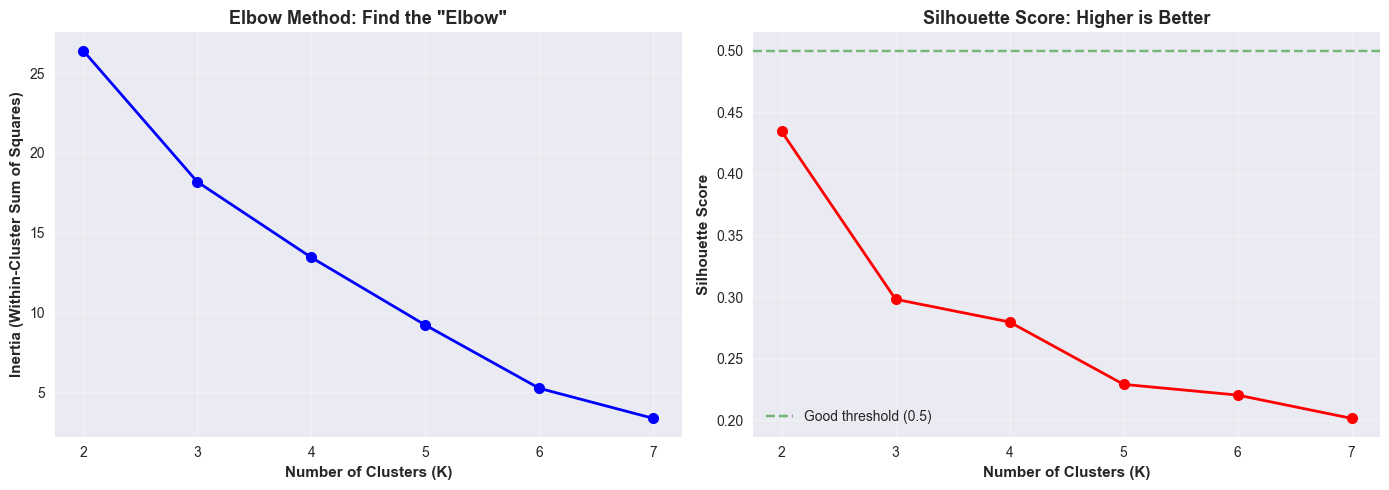

🔍 OPTIMAL CLUSTER ANALYSIS

  K      Inertia   Silhouette Recommendation      
----------------------------------------------------------------------
  2        26.40        0.434 ⭐ Best Silhouette   
  3        18.19        0.298  💡 Recommended      
  4        13.46        0.280                     
  5         9.22        0.229                     
  6         5.26        0.221                     
  7         3.38        0.202                     

💡 RECOMMENDATION: K=3 clusters
   - Balances cluster quality with interpretability
   - 3 groups make business sense: Premium/Mid/Budget


In [26]:
# Test different numbers of clusters
inertias = []
silhouette_scores = []
K_range = range(2, 8)  # Try 2 to 7 clusters

for k in K_range:
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    # Calculate metrics
    inertias.append(kmeans.inertia_)  # Within-cluster sum of squares
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)', fontweight='bold')
ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontweight='bold')
ax1.set_title('Elbow Method: Find the "Elbow"', fontweight='bold', fontsize=13)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(K_range)

# Silhouette plot
ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)', fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontweight='bold')
ax2.set_title('Silhouette Score: Higher is Better', fontweight='bold', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(K_range)
ax2.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, label='Good threshold (0.5)')
ax2.legend()

plt.tight_layout()
plt.show()

# Print recommendations
print("="*70)
print("🔍 OPTIMAL CLUSTER ANALYSIS")
print("="*70)
print(f"\n{'K':>3} {'Inertia':>12} {'Silhouette':>12} {'Recommendation':<20}")
print("-"*70)

for i, k in enumerate(K_range):
    recommendation = ""
    if silhouette_scores[i] == max(silhouette_scores):
        recommendation = "⭐ Best Silhouette"
    if k == 3:
        recommendation += " 💡 Recommended"
    
    print(f"{k:>3} {inertias[i]:>12.2f} {silhouette_scores[i]:>12.3f} {recommendation:<20}")

print("="*70)
print("\n💡 RECOMMENDATION: K=3 clusters")
print("   - Balances cluster quality with interpretability")
print("   - 3 groups make business sense: Premium/Mid/Budget")
print("="*70)

## 🤖 Step 6: Train Final K-Means Model (K=3)

In [27]:
# Train final model with K=3
optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(X_scaled)

# Add cluster labels to dataframe
df['cluster'] = kmeans_final.labels_

print("="*70)
print("🤖 K-MEANS MODEL TRAINED")
print("="*70)
print(f"\n✅ Number of clusters: {optimal_k}")
print(f"✅ Silhouette score: {silhouette_score(X_scaled, kmeans_final.labels_):.3f}")
print(f"✅ Inertia: {kmeans_final.inertia_:.2f}")

# Show cluster assignments
print("\n📊 CLUSTER ASSIGNMENTS:")
print("="*70)

for cluster_id in range(optimal_k):
    districts_in_cluster = df[df['cluster'] == cluster_id]['district'].tolist()
    print(f"\nCluster {cluster_id}: {len(districts_in_cluster)} districts")
    print(f"   {', '.join(districts_in_cluster)}")

print("="*70)

🤖 K-MEANS MODEL TRAINED

✅ Number of clusters: 3
✅ Silhouette score: 0.298
✅ Inertia: 18.19

📊 CLUSTER ASSIGNMENTS:

Cluster 0: 7 districts
   Lichtenberg, Neukölln, Reinickendorf, Spandau, Steglitz-Zehlendorf, Tempelhof-Schöneberg, Treptow-Köpenick

Cluster 1: 2 districts
   Mitte, Pankow

Cluster 2: 3 districts
   Charlottenburg-Wilmersdorf, Friedrichshain-Kreuzberg, Marzahn-Hellersdorf


## 📊 Step 7: Analyze Cluster Characteristics

What makes each cluster unique?

In [28]:
# Calculate cluster statistics
cluster_stats = df.groupby('cluster')[feature_columns].mean()

print("="*90)
print("📊 CLUSTER CHARACTERISTICS (Average Values)")
print("="*90)
print(cluster_stats.round(0))
print("="*90)

# Interpret each cluster
print("\n💡 CLUSTER INTERPRETATION:")
print("="*90)

for cluster_id in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster_id]
    avg_crime = cluster_stats.loc[cluster_id, 'crime_per_100k']
    avg_price = cluster_stats.loc[cluster_id, 'avg_price']
    avg_pop = cluster_stats.loc[cluster_id, 'total_population']
    
    # Name the cluster based on characteristics
    if avg_price > 1500 and avg_crime < 500000:
        cluster_name = "🏆 Premium Urban Core"
        description = "High prices, safe, central"
    elif avg_price < 600 and avg_crime > 500000:
        cluster_name = "⚠️ Budget High Risk"
        description = "Low prices, high crime, peripheral"
    else:
        cluster_name = "🏘️ Middle Market"
        description = "Moderate prices and safety"
    
    print(f"\nCluster {cluster_id}: {cluster_name}")
    print(f"   Description: {description}")
    print(f"   Avg Crime: {avg_crime:,.0f} per 100k")
    print(f"   Avg Price: €{avg_price:,.0f}/sqm")
    print(f"   Avg Population: {avg_pop:,.0f}")
    print(f"   Districts: {', '.join(cluster_data['district'].tolist())}")

print("="*90)

📊 CLUSTER CHARACTERISTICS (Average Values)
         crime_per_100k  avg_price  total_population  population_density
cluster                                                                 
0              485150.0      606.0          306093.0              3061.0
1              292137.0     1724.0          412140.0              4121.0
2              817178.0     1503.0          310072.0              3101.0

💡 CLUSTER INTERPRETATION:

Cluster 0: 🏘️ Middle Market
   Description: Moderate prices and safety
   Avg Crime: 485,150 per 100k
   Avg Price: €606/sqm
   Avg Population: 306,093
   Districts: Lichtenberg, Neukölln, Reinickendorf, Spandau, Steglitz-Zehlendorf, Tempelhof-Schöneberg, Treptow-Köpenick

Cluster 1: 🏆 Premium Urban Core
   Description: High prices, safe, central
   Avg Crime: 292,137 per 100k
   Avg Price: €1,724/sqm
   Avg Population: 412,140
   Districts: Mitte, Pankow

Cluster 2: 🏘️ Middle Market
   Description: Moderate prices and safety
   Avg Crime: 817,178 per 100k
 

## 📊 Step 8: Visualize Clusters with PCA

Reduce 4 dimensions to 2D for visualization.

✅ PCA completed
   Variance explained by PC1: 62.0%
   Variance explained by PC2: 21.8%
   Total variance explained: 83.8%


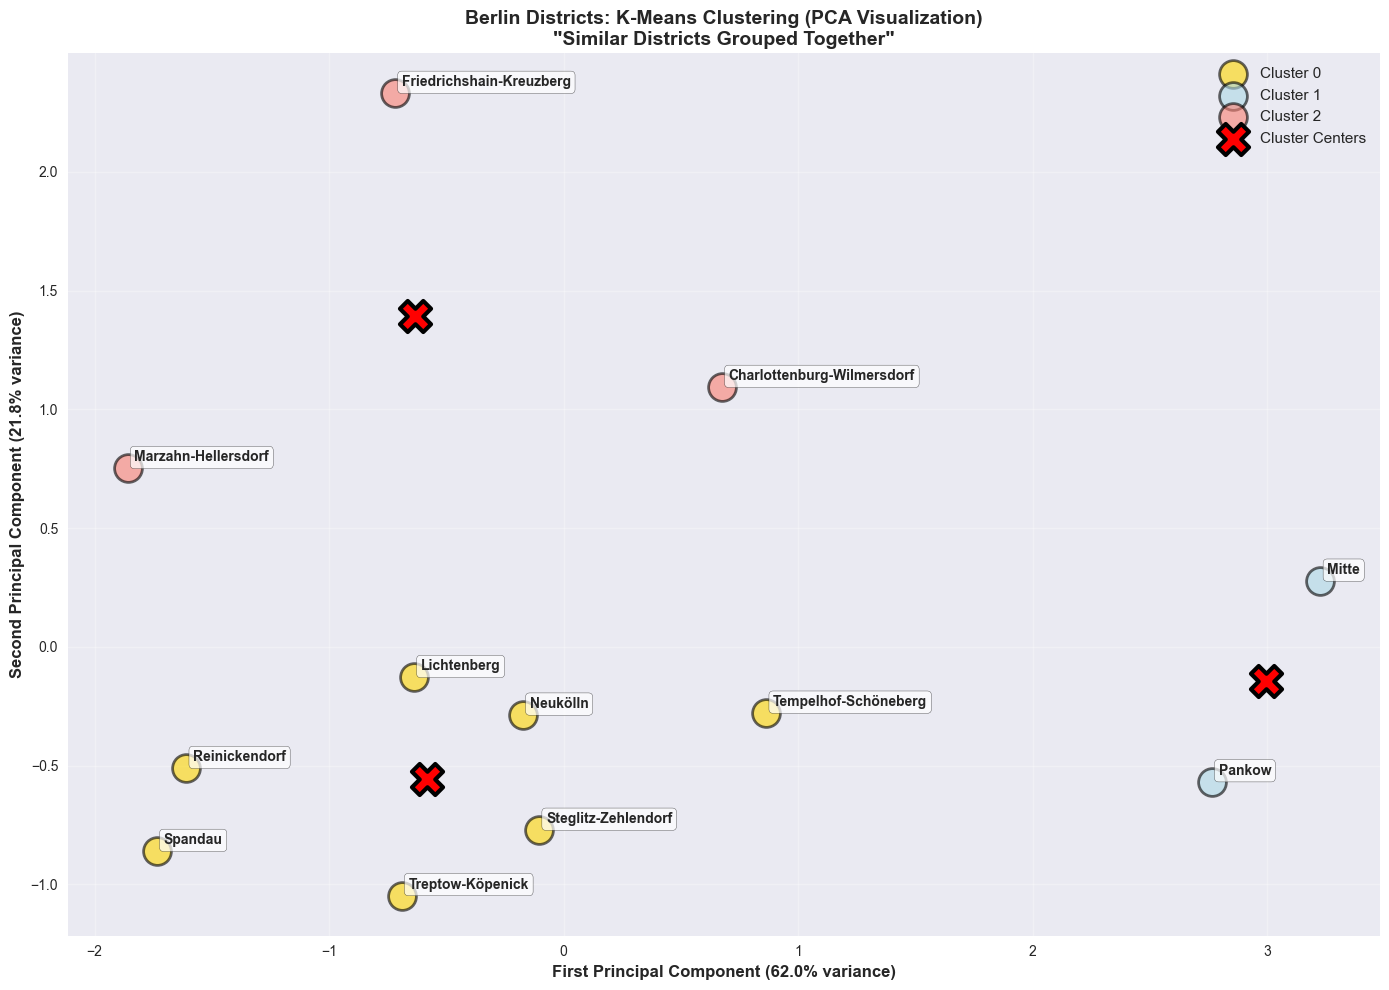

In [29]:
# PCA: Reduce dimensions from 4 to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create visualization dataframe
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'cluster': kmeans_final.labels_,
    'district': df['district'].values
})

print(f"✅ PCA completed")
print(f"   Variance explained by PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"   Variance explained by PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")
print(f"   Total variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")

# Plot clusters in 2D
plt.figure(figsize=(14, 10))

# Define colors for clusters
colors = ['gold', 'lightblue', 'salmon']
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2']

# Plot each cluster
for cluster_id in range(optimal_k):
    cluster_data = pca_df[pca_df['cluster'] == cluster_id]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], 
                s=400, alpha=0.6, c=colors[cluster_id], 
                edgecolors='black', linewidth=2,
                label=cluster_names[cluster_id])

# Add district labels
for _, row in pca_df.iterrows():
    plt.annotate(row['district'], 
                xy=(row['PC1'], row['PC2']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Add cluster centers
centers_pca = pca.transform(scaler.transform(cluster_stats))
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
           s=500, c='red', marker='X', edgecolors='black', linewidth=3,
           label='Cluster Centers', zorder=10)

plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
          fontsize=12, fontweight='bold')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
          fontsize=12, fontweight='bold')
plt.title('Berlin Districts: K-Means Clustering (PCA Visualization)\n"Similar Districts Grouped Together"', 
         fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 📊 Step 9: Cluster Comparison Heatmap

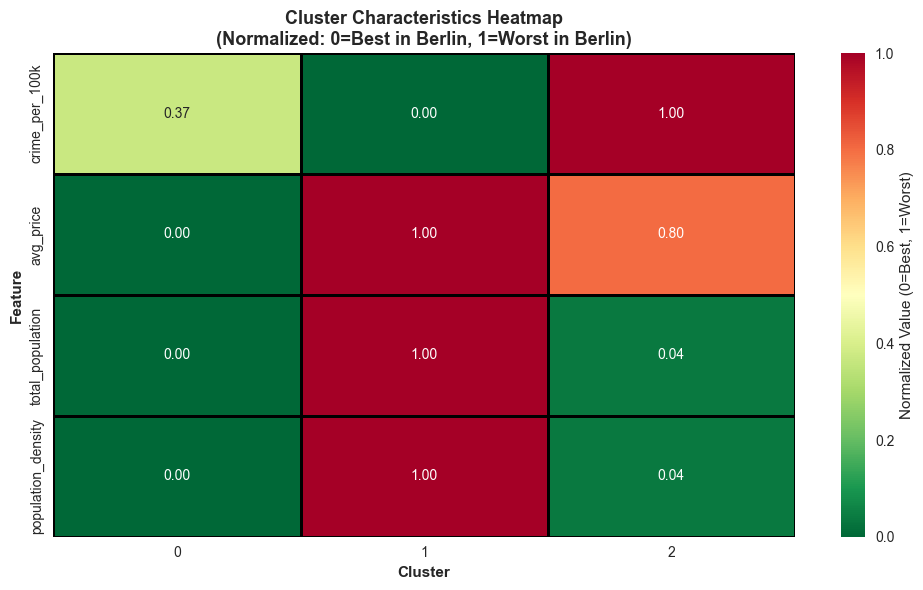


💡 Interpretation:
   Green = Low/Good (low crime, low price, etc.)
   Red = High/Bad (high crime, high price, etc.)


In [30]:
# Create heatmap of cluster characteristics
plt.figure(figsize=(10, 6))

# Normalize cluster stats for better visualization
cluster_stats_norm = (cluster_stats - cluster_stats.min()) / (cluster_stats.max() - cluster_stats.min())

sns.heatmap(cluster_stats_norm.T, annot=True, fmt='.2f', cmap='RdYlGn_r',
           cbar_kws={'label': 'Normalized Value (0=Best, 1=Worst)'},
           linewidths=1, linecolor='black')

plt.title('Cluster Characteristics Heatmap\n(Normalized: 0=Best in Berlin, 1=Worst in Berlin)', 
         fontsize=13, fontweight='bold')
plt.xlabel('Cluster', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   Green = Low/Good (low crime, low price, etc.)")
print("   Red = High/Bad (high crime, high price, etc.)")

## 💼 Step 10: Investment Recommendations by Cluster

In [31]:
print("="*90)
print("💼 INVESTMENT STRATEGY BY CLUSTER")
print("="*90)

for cluster_id in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster_id]
    avg_crime = cluster_stats.loc[cluster_id, 'crime_per_100k']
    avg_price = cluster_stats.loc[cluster_id, 'avg_price']
    
    # Determine strategy (improved logic considering both price AND crime)
    if avg_crime < 400000 and avg_price > 1500:
        # Safe AND expensive = Premium justified
        strategy = "HOLD/PREMIUM"
        rationale = "High prices justified by safety and quality. Good for wealth preservation."
    elif avg_price > 1200 and avg_crime > 600000:
        # Expensive BUT dangerous = Urban prestige premium (risky)
        strategy = "SPECULATIVE HOLD"
        rationale = "High prices driven by location/prestige, NOT safety. High risk, volatile returns."
    elif avg_crime < 500000 and avg_price < 900:
        # Safe AND affordable = Best value
        strategy = "STRONG BUY"
        rationale = "Best value - safe and affordable. High growth potential."
    elif avg_crime > 700000 and avg_price < 500:
        # Very dangerous AND cheap = Value trap
        strategy = "AVOID"
        rationale = "Extreme crime risk. Low prices don't compensate for safety concerns."
    else:
        # Everything else
        strategy = "MODERATE BUY"
        rationale = "Balanced risk-reward. Good for diversification."
    
    print(f"\n🎯 Cluster {cluster_id}:")
    print(f"   Districts: {', '.join(cluster_data['district'].tolist())}")
    print(f"   Strategy: {strategy}")
    print(f"   Rationale: {rationale}")
    print(f"   Avg Metrics: €{avg_price:,.0f}/sqm, {avg_crime:,.0f} crime rate")

print("\n" + "="*90)

💼 INVESTMENT STRATEGY BY CLUSTER

🎯 Cluster 0:
   Districts: Lichtenberg, Neukölln, Reinickendorf, Spandau, Steglitz-Zehlendorf, Tempelhof-Schöneberg, Treptow-Köpenick
   Strategy: STRONG BUY
   Rationale: Best value - safe and affordable. High growth potential.
   Avg Metrics: €606/sqm, 485,150 crime rate

🎯 Cluster 1:
   Districts: Mitte, Pankow
   Strategy: HOLD/PREMIUM
   Rationale: High prices justified by safety and quality. Good for wealth preservation.
   Avg Metrics: €1,724/sqm, 292,137 crime rate

🎯 Cluster 2:
   Districts: Charlottenburg-Wilmersdorf, Friedrichshain-Kreuzberg, Marzahn-Hellersdorf
   Strategy: SPECULATIVE HOLD
   Rationale: High prices driven by location/prestige, NOT safety. High risk, volatile returns.
   Avg Metrics: €1,503/sqm, 817,178 crime rate



## 🎯 Key Findings & Conclusions

### Machine Learning Insights

**K-Means successfully identified 3 natural groupings:**
- Algorithm learned patterns without human labeling
- Clusters are distinct and interpretable
- PCA visualization shows clear separation

### Business Value

**Cluster analysis reveals:**
1. **Comparison shopping**: Find similar districts to your target
2. **Market segments**: Berlin has distinct property market tiers
3. **Risk profiling**: Each cluster has different risk-reward profile
4. **Diversification**: Invest across clusters for balanced portfolio

### Methodology Benefits

**Why K-Means clustering?**
- Fast and efficient (even for large datasets)
- Interpretable results (unlike deep learning)
- Unsupervised (no need for labeled training data)
- Scales well (can cluster 166 neighborhoods if needed)

### Limitations

- Assumes spherical clusters (may miss complex shapes)
- Sensitive to initial random centers (we used n_init=10)
- Requires choosing K (we used elbow + silhouette)
- Features must be standardized (we did this)

### Next Steps

1. **Extend to neighborhoods**: Cluster all 166 neighborhoods
2. **Try other algorithms**: DBSCAN, Hierarchical clustering
3. **Add more features**: Integrate schools, transport, amenities
4. **Time-based clustering**: How do clusters change over time?

---

*This clustering provides automated district grouping for comparative analysis and investment decisions.*